# COMMUNITY DISCOVERY
Nella seguente sezione si individueranno le comunità applicando i seguenti tre **algoritmi di Community Discovery** utilizzando la libreria [**CDlib**](https://cdlib.readthedocs.io/en/latest/index.html)

Algoritmi:
- [**Louvain**](#Louvain) (Internal Density Algorithm) 
- [**Label Propagation**](#labelprop) (Percolazione)
- [**K-Clique**](#kclique) (Structure Definition)

Su questi tre algoritmi verranno fatte sia valutazioni interne (in termini di conductance, AND, IED ecc.) e [esterne](#exval) (in termini di **Normalized Mutual Information** e **Normalized F1**)

In [1]:
#installo cdlib
!pip install cdlib

In [2]:
import cdlib
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import powerlaw
import seaborn as sns

from cdlib import algorithms, evaluation, ensemble, viz, readwrite

Note: to be able to use all crisp methods, you need to install some additional packages:  {'infomap', 'wurlitzer', 'karateclub', 'graph_tool'}
Note: to be able to use all overlapping methods, you need to install some additional packages:  {'karateclub', 'ASLPAw'}
Note: to be able to use all bipartite methods, you need to install some additional packages:  {'infomap', 'wurlitzer'}


In [3]:
def read_net(filename):
    g = nx.Graph()
    with open(filename) as f:
        f.readline()
        for l in f:
            l = l.split(",")
            g.add_edge(l[1], l[3]) #, weight=int(float(l[5].rstrip('\n'))))
    return g

lista = []

def coms_evaluation(algoritmo, nome_algoritmo):
    print ('--------------------------------------------------------------\n Valutazione comunità ottenute con algoritmo', nome_algoritmo, '\n-------------------------------------------------------------\n')
    print('- Copertura nodi:', algoritmo.node_coverage)
    print('- Modularity:',  algoritmo.newman_girvan_modularity())
    print('- Numero Nodi:', algoritmo.size())
    print('- Avg Distance:', algoritmo.avg_distance())
    print('- Conductance:', algoritmo.conductance())
    print('- Avarage Node Degree:', algoritmo.average_internal_degree())
    print('- Internal Edge Density:', algoritmo.internal_edge_density())
    
    lista.append((nome_algoritmo, algoritmo.size(summary = False)))
    

def stampa_nodi_coms (algoritmo, nome_algoritmo):
    n_nodi = []
    for i in algoritmo.communities:
        n_nodi += i
    n_nodi = list(set(n_nodi))
    print("Nodi nelle communities identificate con l'algoritmo", nome_algoritmo,':', len(n_nodi))
    

Creazione del grafo 

In [4]:
df = pd.read_csv("../data_collection/data/df_grafo_pesato.csv", skipinitialspace=True, na_values='?', keep_default_na=True)
del[df['Unnamed: 0']]
g = read_net("../data_collection/data/df_grafo_pesato.csv")

Per individuare le comunità utilizzerò un grafo diretto e non pesato

In [5]:
g = g.to_undirected()
nx.info(g)

'Graph with 18266 nodes and 21697 edges'

In [6]:
df

,source,id_source,target,id_target,weights
0,jwl2nd,4563241355,chanleycourttv,4730732546,1.000000
1,simplyslj,1518917881119059968,theemilydbaker,22594853,0.952055
2,jwl2nd,4563241355,courttv,1031946753510203392,0.924658
3,simplyslj,1518917881119059968,legalbytesmedia,1262475778631106560,0.914384
4,adrferg,1074757149748854792,courttv,1031946753510203392,0.633562
...,...,...,...,...,...
21708,intheone9,208950166,ThatUmbrella,901030183213445125,0.000000
21709,intheone9,208950166,dailymailuk,111556423,0.000000
21710,intheone9,208950166,elainebhoft,1380604861486665730,0.000000
21711,intheone9,208950166,girlsreallyrule,580312540,0.000000


-----

# LOUVAIN <a id = 'Louvain'> </a>

### Parameter Tuning
- *resolution*
- *randomize* 

In [7]:
resolution_louvain = ensemble.Parameter(name="resolution", start=0.1, end=1, step=0.1)
randomize_louvain = ensemble.BoolParameter(name="randomize")

communities_louvain, scoring_louvain = ensemble.random_search(graph=g, method=algorithms.louvain,
                                              parameters=[resolution_louvain, randomize_louvain],
                                              quality_score = evaluation.erdos_renyi_modularity,
                                              instances = 3, aggregate=max)

print("Configuration: %s \nScoring: %s" %(communities_louvain.method_parameters, scoring_louvain))

Configuration: {'weight': 'weight', 'resolution': 0.5, 'randomize': False} 
Scoring: FitnessResult(min=None, max=None, score=0.7820624696434636, std=None)


In [8]:
louvain_coms =  algorithms.louvain(g, resolution=0.9, randomize=False)

In [9]:
louvain_coms

### Valutazione interna 

In [10]:
print('Sovrapposizione communities identificate con algoritmo Louvain (con pesi): ', louvain_coms.overlap)

Sovrapposizione communities identificate con algoritmo Louvain (con pesi):  False


In [11]:
coms_evaluation(louvain_coms, "Louvain")

--------------------------------------------------------------
 Valutazione comunità ottenute con algoritmo Louvain 
-------------------------------------------------------------

- Copertura nodi: 1.0
- Modularity: FitnessResult(min=None, max=None, score=0.7941856342711396, std=None)
- Numero Nodi: FitnessResult(min=1, max=1468, score=7.419171405361495, std=52.4595833562343)
- Avg Distance: FitnessResult(min=0, max=8.633618090452261, score=1.19140051681419, std=0.5840647245306968)
- Conductance: FitnessResult(min=0.0, max=0.2872727272727273, score=0.003087559167734226, std=0.024490192471284908)
- Avarage Node Degree: FitnessResult(min=1.0, max=3.5, score=1.1585003575925221, std=0.2885668501979991)
- Internal Edge Density: FitnessResult(min=0, max=3.0, score=0.8538837272021891, std=0.2585624708673986)


In [12]:
louvain_coms.communities 

[['simplyslj',
  'theemilydbaker',
  'legalbytesmedia',
  'tobiastheginger',
  'thatumbrella',
  'rekietalaw',
  'esneet4113',
  'yellowflashguy',
  'aburkhartlaw',
  'IanRunkle',
  'inspectorstocks',
  'kyduiguy',
  'houseinhabit',
  'ianrunkle',
  'colleenbaker4',
  'bronk34',
  'thelawkoala',
  'leannen04',
  'jamesfromcourt',
  'popcornedplanet',
  'gellertdepp',
  'joshthepunished',
  'emmaleekelly5',
  'comegeeksome1',
  'junktruth',
  'andysignore',
  'lawselfdefense',
  'spirituallyemp1',
  'lonestarmomcom',
  'steviejraw',
  'lumberlaw',
  'niermanjoe',
  'RekietaLaw',
  'MelancholyDolli',
  'unabashedgator',
  'brooklynburning',
  'wakeyourvintage',
  'lakeside17',
  'teresalolvera',
  'johnnydepp__ll',
  'dobedobedolala',
  'rhomany',
  'brelana88',
  'nancyomarin',
  'tartanbulletz',
  'r_telari',
  'ffxcircuitcourt',
  'rohitkulk29',
  'govchad',
  'lil_skyscraper_',
  'epicesquire',
  'faranbalanced',
  'LumberLaw',
  'novatempest_',
  'lafamlaw',
  'foxla',
  'ca_divorce

In [13]:
print("Numero comunità identificate con l'algoritmo Louvain: ", len(louvain_coms.communities))


Numero comunità identificate con l'algoritmo Louvain:  2462


In [14]:
stampa_nodi_coms(louvain_coms, 'Louvain')

Nodi nelle communities identificate con l'algoritmo Louvain : 18266


In [15]:
df_comunities_l = pd.DataFrame(louvain_coms.communities)
df_comunities_l = df_comunities_l.transpose()
string_names = ['community_'+ str(i) for i, c in enumerate(louvain_coms.communities)] 
df_comunities_l.columns = string_names

In [16]:
df_comunities_l

,community_0,community_1,community_2,community_3,community_4,community_5,community_6,community_7,community_8,community_9,...,community_2452,community_2453,community_2454,community_2455,community_2456,community_2457,community_2458,community_2459,community_2460,community_2461
0,simplyslj,decquine,realamberheard,jwl2nd,faisorler,elonmusk,GellertDepp,itsraining2,stirgussa,SchizoSkits,...,mr_bet01,mybizandlife,thetalentguru,z2htv,socialrobbers,stoptechy1,aylinaydindal,averagebeing99,lekucciglobal,faceswaponline
1,theemilydbaker,deppheardtruth,lisasays_9,chanleycourttv,jossytweets,malinlovesshx,1800imnosey,heavy69342238,__towanda,robert__leonard,...,None,None,None,None,None,None,None,None,None,None
2,legalbytesmedia,aronberg,briajasminelynn,courttv,Bunmicheshire,fearfully_madee,queenoflockdown,nypost,Eve_Barlow,martinsrosie,...,None,None,None,None,None,None,None,None,None,None
3,tobiastheginger,ixchelroy,knuthaugen6,adrferg,DrProudman,cherienbenni,Bee75Mo,witch_natural,alargue4rfc,bnopeace69,...,None,None,None,None,None,None,None,None,None,None
4,thatumbrella,guymrdth,texasmagnolia2,juliecourttv,mensurvivetoo,ghostinkiss,CuteCrook,Newsweek,finwinston,DaaniMonday,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1463,Clementhillsong,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
1464,JackieG4111,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
1465,csmcdncr99,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
1466,inkedonculture,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


In [17]:
df_comunities_l.to_csv("../data_collection/data/comunità/coms_louvain.csv")

In [18]:
df_comunities_l.shape

(1468, 2462)

-----

# LABEL PROPAGATION <a id = 'labelprop'> </a>

In [19]:
labelp_coms = algorithms.label_propagation(g)

### Valutazione interna 

In [20]:
print('Sovrapposizione communities identificate con algoritmo Label Propagation:', labelp_coms.overlap)

Sovrapposizione communities identificate con algoritmo Label Propagation: False


### Valutazione interna 

In [21]:
coms_evaluation(labelp_coms, "Label Propagation")

--------------------------------------------------------------
 Valutazione comunità ottenute con algoritmo Label Propagation 
-------------------------------------------------------------

- Copertura nodi: 1.0
- Modularity: FitnessResult(min=None, max=None, score=0.6554268112978178, std=None)
- Numero Nodi: FitnessResult(min=1, max=449, score=3.8682761541719612, std=12.589233109841164)
- Avg Distance: FitnessResult(min=0, max=3.173520521794464, score=1.1999321205247506, std=0.30227742587640266)
- Conductance: FitnessResult(min=0.0, max=0.9166666666666666, score=0.20283221840226986, std=0.23559966822192818)
- Avarage Node Degree: FitnessResult(min=1.0, max=3.8797327394209353, score=1.2126632453236696, std=0.30333219402514744)
- Internal Edge Density: FitnessResult(min=0, max=2.0, score=0.7984670763538406, std=0.2751526801342246)


In [22]:
labelp_coms.communities

[['benzai_daegan',
  'flowender11',
  'kyliesm29507820',
  'llivv0123',
  'msmelodius',
  'pacellitroy',
  'systemicdunking',
  'rvanova01',
  '_talolie',
  'zimmbiogal',
  'sydneyadmirer',
  'frenchyinlondon',
  'mousears7',
  'leeann_ky',
  'dianagurrola10',
  'geekbrenda',
  'littlemsrobbie',
  'crobb203',
  '0iivie',
  'djliquiddrip',
  '1atomikpunk',
  'justice4theline',
  'didulahatangala',
  'linzernic3',
  'daveforgiveness',
  'tallulah_bear7',
  'ianrunkle',
  'pablo77110484',
  'kimberlykurz2',
  'urshy74',
  'saifed99',
  'cfold2',
  'cindyelise',
  'crazymomma007',
  'kimberlyconroy',
  '_bre_lemus_',
  'ms_blondeasian',
  'simplyhappysm',
  'anotherothernic',
  'overthebeaaan',
  'justice4line',
  'lumberlaw',
  'rjs11123',
  'pollylogic',
  'beansandwaffles',
  'optistrong',
  'absterwales',
  'kaelhyun',
  'saltysusan_',
  'ruthmariebutler',
  'hcampbell419',
  'a_amanda_gomes',
  'cpu_tech0110',
  'nyrex_x',
  'marisas1985',
  'tomr15288961',
  'texas__nana',
  'fgirlof

In [23]:
print("Numero comunità identificate con l'algoritmo Label Propagation: ", len(labelp_coms.communities))

Numero comunità identificate con l'algoritmo Label Propagation:  4722


In [24]:
stampa_nodi_coms(labelp_coms, 'Label Propagation')

Nodi nelle communities identificate con l'algoritmo Label Propagation : 18266


Esporto le comunità identificate con **Label propagation**

In [25]:
df_comunities_lp = pd.DataFrame(labelp_coms.communities)
df_comunities_lp = df_comunities_lp.transpose()
string_names = ['community_'+ str(i) for i, c in enumerate(labelp_coms.communities)] 
df_comunities_lp.columns = string_names

In [26]:
df_comunities_lp

,community_0,community_1,community_2,community_3,community_4,community_5,community_6,community_7,community_8,community_9,...,community_4712,community_4713,community_4714,community_4715,community_4716,community_4717,community_4718,community_4719,community_4720,community_4721
0,benzai_daegan,soulsenlighten,mar7729,shanbamanana,kayvandej,geestfu,mrs_right_a,hollienemitz,elyse4design,shefsam1,...,thetalentguru,z2htv,socialrobbers,stoptechy1,ex0t1c_markets,aylinaydindal,averagebeing99,lekucciglobal,faceswaponline,icmynft
1,flowender11,big_d_rants,memehoe50,janielacy,jessica41515,louist91ofTPWK,moinshekh,mikepamelap,pannlewis44,lissy7318,...,None,None,None,None,None,None,None,None,None,None
2,kyliesm29507820,podrandomly,sicgirl1078,daly_anna,demoncreegan,PresidentSweden,barbarajen,rezzachamp,ebikeadvocate,aad_crypto,...,None,None,None,None,None,None,None,None,None,None
3,llivv0123,key13673237,deeb_thee,KeiranSouthern,y2hero,LeJutko,1776_2021_0,burgenah,onlylight210,jayday230,...,None,None,None,None,None,None,None,None,None,None
4,msmelodius,leximi84,mellymellz____,bondjane007,hellsurrey,KimwhittyKim,LillyJane916,kiraeyl,GermainLussier,mrs_gonzalez05,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
444,jdah2022trial,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
445,foldsxs,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
446,deniseknows1,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
447,red___shoes,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


In [27]:
df_comunities_lp.to_csv("../data_collection/data/comunità/coms_lp.csv")

In [28]:
df_comunities_lp.shape

(449, 4722)

----

# K-CLIQUE <a id = 'kclique'> </a>

Parameter tuning (numero K)

In [29]:
k = ensemble.Parameter(name = "k", start = 2, end = 15, step = 1)

kclique_coms, scoring_k = ensemble.random_search(graph = g, method = algorithms.kclique,
                                              parameters = [k],
                                              quality_score = evaluation.erdos_renyi_modularity,
                                              instances = 3, aggregate=max)

print("Configuration: %s \nScoring: %s" %(kclique_coms.method_parameters, scoring_k))

Configuration: {'k': 4} 
Scoring: FitnessResult(min=None, max=None, score=0.0036402590732196463, std=None)


In [30]:
kclique_coms = algorithms.kclique(g, k=3)
kclique_coms

### Valutazione interna 

In [31]:
print('Sovrapposizione communities identificate con algoritmo Louvain (con pesi): ', kclique_coms.overlap)
#nel k-clique ci sono sovrapposizioni

Sovrapposizione communities identificate con algoritmo Louvain (con pesi):  True


In [32]:
coms_evaluation(kclique_coms, "K-Clique (k = 3)")

--------------------------------------------------------------
 Valutazione comunità ottenute con algoritmo K-Clique (k = 3) 
-------------------------------------------------------------

- Copertura nodi: 0.02989160188328041
- Modularity: FitnessResult(min=None, max=None, score=0.01273936545844763, std=None)
- Numero Nodi: FitnessResult(min=3, max=254, score=7.0, std=26.565641971037202)
- Avg Distance: FitnessResult(min=1.0, max=2.9206685132737853, score=1.1242714804102472, std=0.2773980003122679)
- Conductance: FitnessResult(min=0.0, max=0.9908675799086758, score=0.7619912677873698, std=0.28907527453167314)
- Avarage Node Degree: FitnessResult(min=2.0, max=7.417322834645669, score=2.384450868280295, std=0.7613633339829603)
- Internal Edge Density: FitnessResult(min=0.029317481559864307, max=1.6666666666666667, score=0.9068610082489726, std=0.2204938415078105)


In [33]:
kclique_coms.communities

[['shanbamanana',
  'heatherventures',
  'scryndi',
  'asl4nrawkz',
  'source411',
  'govchad',
  'bondjane007',
  'Raven__Smith',
  'janna_bastone',
  'redzesty11',
  'andysignore',
  'ashleykristen64',
  'rvanova01',
  'abelci0',
  'borghardtlaw',
  'boydhelenanne',
  'esneet4113',
  'mderndarkwizard',
  'itsadriienne',
  'zimmbiogal',
  'marshmallow8753',
  'bluerosegirl',
  'gemrosep',
  'mousears7',
  'bartonbella1',
  'jwl2nd',
  'lulatrixiebelle',
  'planetmonkie',
  'squidlord',
  'youtube',
  'washingtonpost',
  'alison_diane',
  'devilsnight',
  'theemilydbaker',
  'iamnenestwin',
  'popcornedplanet',
  '0iivie',
  'djliquiddrip',
  'realdavidgrace',
  'rekietalaw',
  'comedyfan1981',
  'anyaglows',
  'steviejraw',
  'kyduiguy',
  'FormerPr',
  'katarific2010',
  'shmuue',
  'ica_baby_la',
  'apple121',
  'thatbrianfella',
  'Truthse10335075',
  'amberrosee422',
  'lonestarmomcom',
  'whatifanynani',
  'miamillerauthor',
  'laurennfarmerr',
  'vampire_fairy',
  'misschieffe',

In [34]:
print("Numero comunità identificate con l'algoritmo K-Clique: ", len(kclique_coms.communities))

Numero comunità identificate con l'algoritmo K-Clique:  90


In [35]:
stampa_nodi_coms(kclique_coms, 'K-Clique')

Nodi nelle communities identificate con l'algoritmo K-Clique : 546


In [36]:
kclique_coms = algorithms.kclique(g, k=3)
kclique_coms

Esporto le comunità identificate con **Kclique**

In [37]:
df_comunities_kc = pd.DataFrame(kclique_coms.communities) # modificare communities con kclique_coms.communities
df_comunities_kc = df_comunities_kc.transpose()
string_names = ['community_'+ str(i) for i, c in enumerate(kclique_coms.communities)] 
df_comunities_kc.columns = string_names

In [38]:
df_comunities_kc

,community_0,community_1,community_2,community_3,community_4,community_5,community_6,community_7,community_8,community_9,...,community_80,community_81,community_82,community_83,community_84,community_85,community_86,community_87,community_88,community_89
0,shanbamanana,Angenette5,brijh,elonmusk,canada316,Cerebus79,traceybaby,nataliesonya,beyondthebench1,Lons,...,realannaowens,esneet4113,227thomas,TheEmilyDBaker,putneyswope9,michaelglflood,abc,rekietalaw,misstruthadare,joflohoosier
1,heatherventures,allezupyourass,ChrissysBlog,justagirl043,robert__leonard,b_sistah,colonelkurtz99,Ihaveadream0101,knackbags,haggisreflux,...,DaniMet1,ssolorio77,j3lte,keep_itt_movinn,theview,julie_sweet_,sadittymommy,awesomismmom,martinsrosie,claracluck33
2,scryndi,hlntv,farrisflagg,barbaraem77,nan4bsb,Raven__Smith,laurieleannie,trotdarrow,nickwriteswords,ljsandahl,...,whosgunnadoit,kyduiguy,kyduiguy,toothfairylala,danabrams,newscomauhq,ca_divorce,hunleyeric,Sibilla08726941,DrProudman
3,asl4nrawkz,wiseaudra,iamprettypetty,tallie_anne,malik_eva,truthfairyland,aburkhartlaw,ihaveadream0101,etbnetwork,raccoonclubhous,...,None,None,None,None,None,None,None,None,None,None
4,source411,castanzageorgie,CLady62,warriorxqueeng,DrProudman,babetterthanmee,tericarson,deppheardtrial,nmorgasenradio,mandoq3r0,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249,lorraine_hickey,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
250,marsupial_gamer,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
251,channerz_maiden,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
252,voguemagazine,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


In [39]:
df_comunities_kc.to_csv("../data_collection/data/comunità/coms_kc.csv")

In [40]:
df_comunities_kc.shape

(254, 90)

-----

# EXTERNAL EVALUATION <a id = 'exval'></a>

- normalized mutual information
- normalized f1 score

###  Normalized Mutual Information (NMI)
- louvain vs label prop

In [41]:
evaluation.normalized_mutual_information(labelp_coms, louvain_coms)

MatchingResult(score=0.8107437980173448, std=None)

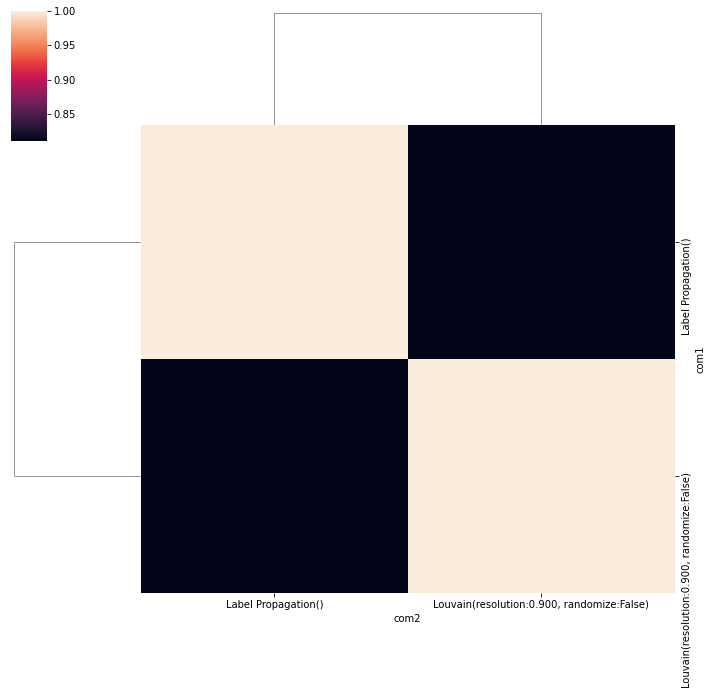

In [42]:
#matrice nmi tra Louvain e label prop
# kclique non si può usare perché non copre lo stesso insieme di nodi degli altri due algoritmi
viz.plot_sim_matrix([labelp_coms, louvain_coms],evaluation.normalized_mutual_information)
plt.savefig('plots/CD/matrix_louvain_labelp_nmi')

### Normalized F1
- louvain vs label propagation
- k-clique vs Louvain
- label propagation vs k-clique

In [43]:
labelp_coms

In [44]:
evaluation.f1(labelp_coms, louvain_coms)

MatchingResult(score=0.5332966334956595, std=0.47798326494793564)

In [45]:
evaluation.f1(kclique_coms, louvain_coms)

MatchingResult(score=0.08958762886597939, std=0.22919364488847488)

In [46]:
evaluation.f1(kclique_coms, labelp_coms)

MatchingResult(score=0.3318487394957983, std=0.2689661700840305)

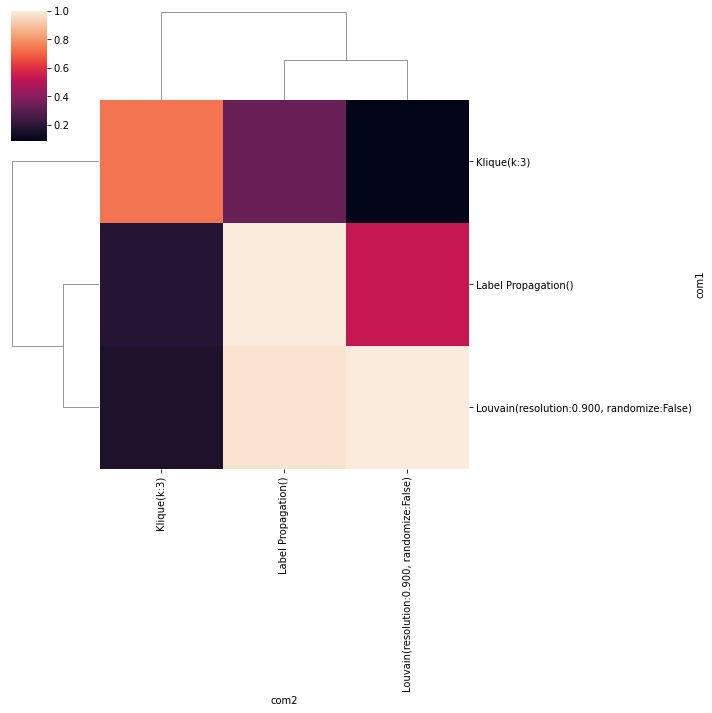

In [47]:
#matrice nf1 tra tutti e tre gli algoritmi
clustermap = viz.plot_sim_matrix([kclique_coms, louvain_coms,labelp_coms ],evaluation.f1)
plt.savefig('plots/CD/matrix_louvain_labelp_kclique_f1')

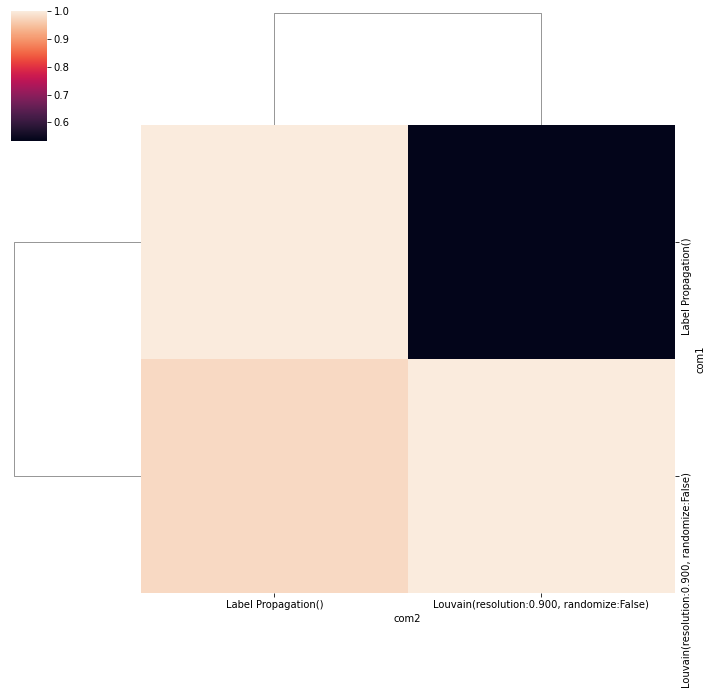

In [48]:
#matrice nf1 tra Louvain e label prop
clustermap = viz.plot_sim_matrix([labelp_coms,louvain_coms],evaluation.f1)
plt.savefig('plots/CD/matrix_louvain_labelp_f1')

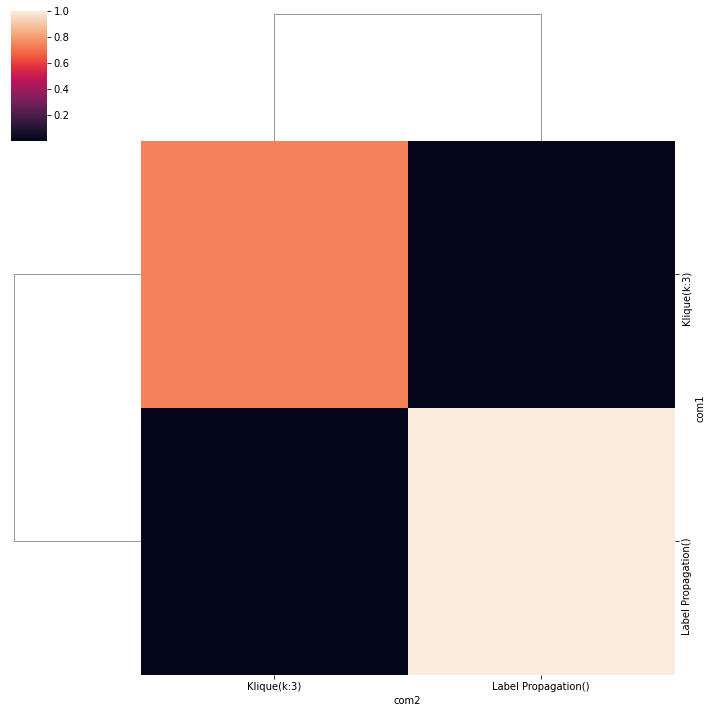

In [49]:
#matrice nf1 tra k-clique e label prop
clustermap = viz.plot_sim_matrix([kclique_coms, labelp_coms],evaluation.nf1)
plt.savefig('plots/CD/matrix_louvain_kclique_f1')

### Visualizzazione dei risultati ottenuti dalla valutazione esterna delle communities

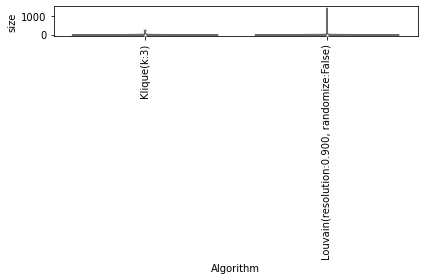

In [50]:
# violin plot 
violinplot = viz.plot_com_stat([kclique_coms,louvain_coms],evaluation.size)

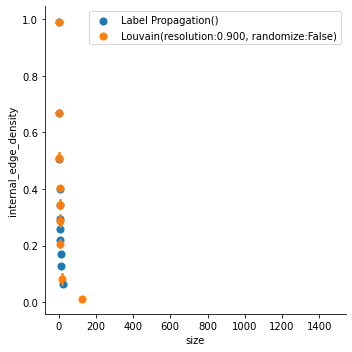

In [51]:
# relazione tra le proprietà 
viz.plot_com_properties_relation([labelp_coms,louvain_coms], evaluation.size, evaluation.internal_edge_density)
plt.savefig('plots/CD/properties_relation_louvain_labelp')

### Boxplot dei tre algoritmi

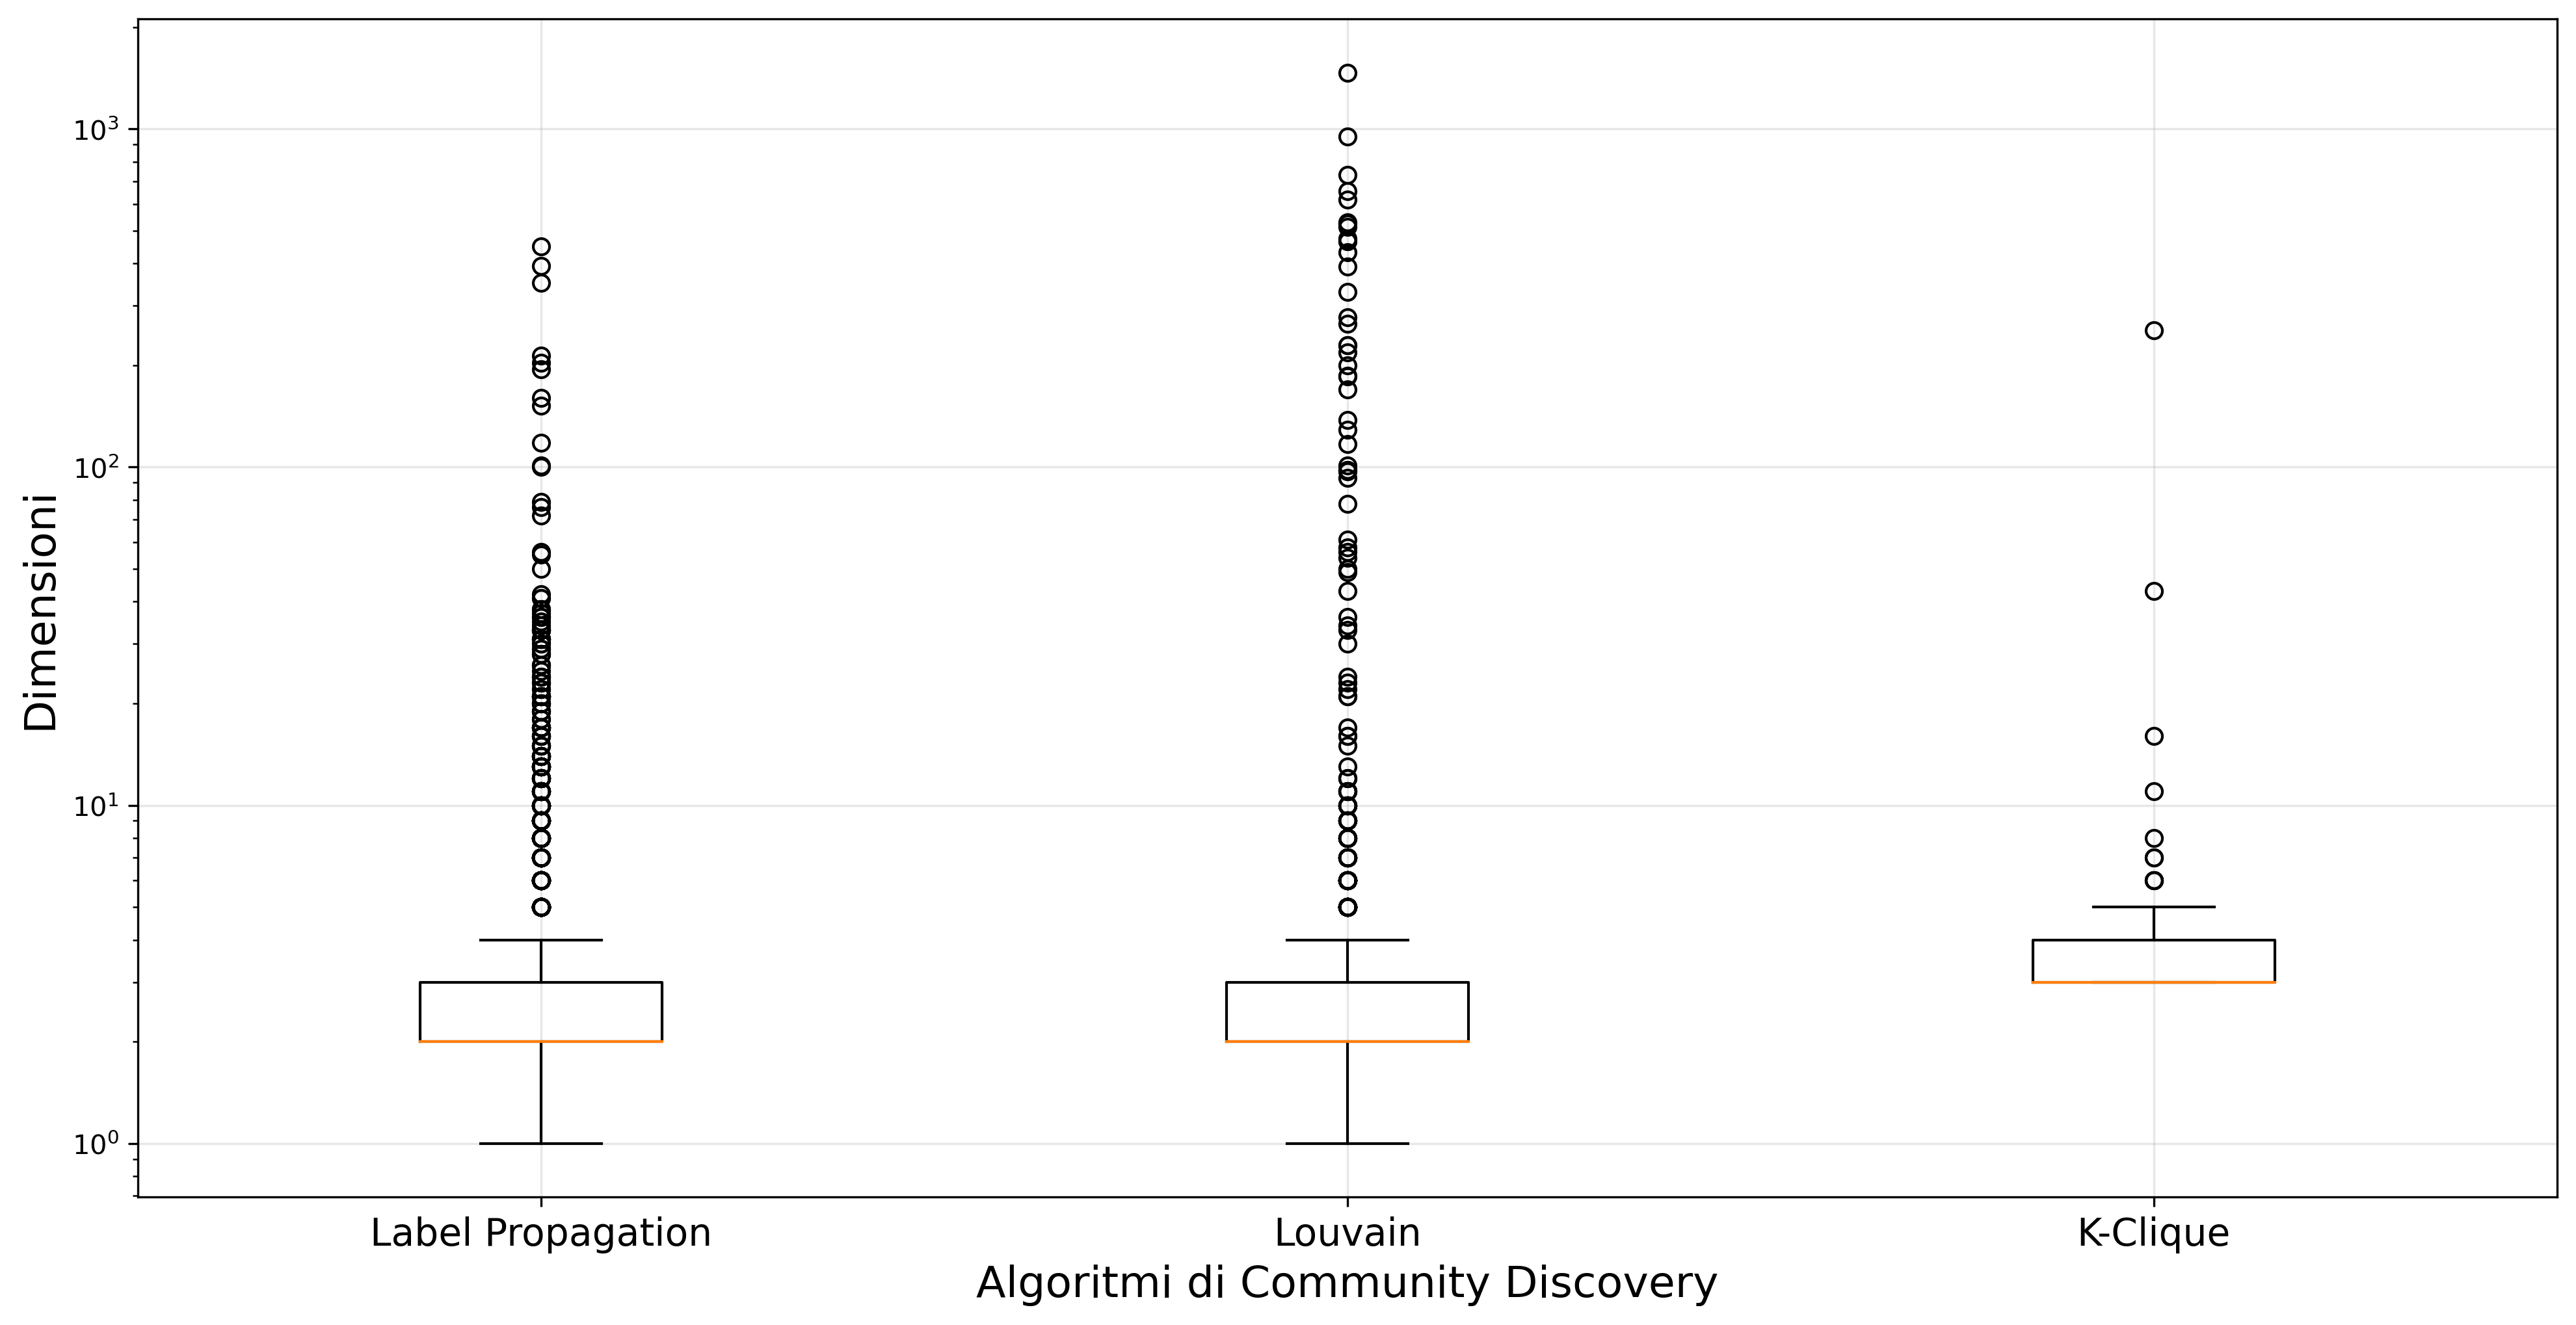

In [52]:
metodi = [('Label Propagation',labelp_coms.size(summary = False)), ('Louvain', louvain_coms.size(summary = False)), ('K-Clique', kclique_coms.size(summary = False))]

size = []
labels = []

for i in range(len(metodi)):
    labels.append(metodi[i][0])
    size.append(metodi[i][1])
fig = plt.figure(figsize=(16,8), dpi= 300)
ax = fig.add_subplot(111)
plt.boxplot(size,labels=labels)


plt.xlabel('Algoritmi di Community Discovery', fontsize = 16)
plt.ylabel("Dimensioni", fontsize = 16)
plt.grid(axis='both', alpha=.3)
#plt.title("Boxplot Algoritmi Community Discovery", fontsize = 18)
plt.yscale("log")
plt.xticks(fontsize = 14)
plt.savefig('plots/CD/boxplot_CD')


plt.show()